In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import glob
import os
import matplotlib as mpl

mpl.rcParams.update({
    "font.size": 12,          
    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
})


These scripts generate the graphics presented in our paper. The csv files for the execution are available in RQ4/*.csv in data folder

In [ ]:
issues_pkl = glob.glob(os.path.join('./issues_closings', '*.pkl'))
issues_df = pd.concat([pd.read_pickle(file) for file in issues_pkl], ignore_index=True)
issues_df

issues_df['repo'] = issues_df['url'].str.extract(r'https?://github\.com/[^/]+/([^/]+)', expand=False)
pairs = pd.read_csv('reviewed_issues.csv')

,number,url,createdAt,closedAt,repo
0,14432,https://github.com/nestjs/nest/issues/14432,2025-01-16T10:12:56Z,2025-01-20T11:34:53Z,nest
1,14823,https://github.com/nestjs/nest/issues/14823,2025-03-21T14:13:34Z,2025-03-24T07:21:33Z,nest
2,14791,https://github.com/nestjs/nest/issues/14791,2025-03-17T21:59:50Z,2025-03-18T10:15:35Z,nest
3,14664,https://github.com/nestjs/nest/issues/14664,2025-02-19T12:22:18Z,2025-03-07T07:25:58Z,nest
4,14911,https://github.com/nestjs/nest/issues/14911,2025-04-05T04:02:58Z,2025-04-07T07:04:00Z,nest
...,...,...,...,...,...
33639,19136,https://github.com/huggingface/transformers/is...,2022-09-21T09:10:47Z,2022-12-12T18:13:11Z,transformers
33640,18724,https://github.com/huggingface/transformers/is...,2022-08-22T19:54:28Z,2022-12-02T08:13:27Z,transformers
33641,18437,https://github.com/huggingface/transformers/is...,2022-08-02T21:22:29Z,2022-12-30T07:35:29Z,transformers
33642,18036,https://github.com/huggingface/transformers/is...,2022-07-05T20:44:11Z,2022-12-06T15:02:50Z,transformers


In [4]:
cols = ['owner', 'project', 'issue_1', 'issue_2', 'codes', 'trivial?']
keep = [c for c in cols if c in pairs.columns]
pairs_slim = pairs[keep].copy()

iss_lookup = issues_df.set_index(['repo', 'number'])
created_map = iss_lookup['createdAt'].to_dict()
closed_map = iss_lookup['closedAt'].to_dict()

pairs_slim['issue_1_key'] = list(zip(pairs_slim['project'], pairs_slim['issue_1']))
pairs_slim['issue_2_key'] = list(zip(pairs_slim['project'], pairs_slim['issue_2']))

pairs_slim['issue_1_createdAt'] = pairs_slim['issue_1_key'].map(created_map)
pairs_slim['issue_1_closedAt']  = pairs_slim['issue_1_key'].map(closed_map)
pairs_slim['issue_2_createdAt'] = pairs_slim['issue_2_key'].map(created_map)
pairs_slim['issue_2_closedAt']  = pairs_slim['issue_2_key'].map(closed_map)

pairs_slim.drop(columns=['issue_1_key', 'issue_2_key'], inplace=True)

pairs_slim

pairs_slim['issue_1_createdAt_dt'] = pd.to_datetime(pairs_slim['issue_1_createdAt'])
pairs_slim['issue_2_createdAt_dt'] = pd.to_datetime(pairs_slim['issue_2_createdAt'])
pairs_slim['issue_1_closedAt_dt']  = pd.to_datetime(pairs_slim['issue_1_closedAt'])
pairs_slim['issue_2_closedAt_dt']  = pd.to_datetime(pairs_slim['issue_2_closedAt'])

pairs_slim['created_diff'] = pairs_slim['issue_2_createdAt_dt'] - pairs_slim['issue_1_createdAt_dt']
pairs_slim['closed_diff']  = pairs_slim['issue_2_closedAt_dt']  - pairs_slim['issue_1_closedAt_dt']

def _closed_to_next_created(row):
    if row['issue_1'] < row['issue_2']:
        diff = row['issue_1_closedAt_dt'] - row['issue_2_createdAt_dt']
    else:
        diff = row['issue_2_closedAt_dt'] - row['issue_1_createdAt_dt']
    return diff

pairs_slim['closed_to_next_created_diff'] = pairs_slim.apply(_closed_to_next_created, axis=1)
pairs_slim['closed_to_next_created_days'] = pairs_slim['closed_to_next_created_diff'].abs().dt.total_seconds() / 86400

pairs_slim['created_diff_days'] = pairs_slim['created_diff'].abs().dt.total_seconds() / 86400
pairs_slim['closed_diff_days']  = pairs_slim['closed_diff'].abs().dt.total_seconds()  / 86400

pairs_slim
pairs_slim.describe()


,issue_1,issue_2,created_diff,closed_diff,closed_to_next_created_diff,closed_to_next_created_days,created_diff_days,closed_diff_days
count,250.000000,250.000000,250,250,250,250.000000,250.000000,250.000000
mean,21519.140000,23434.940000,187 days 09:16:23.976000,146 days 22:49:45.700000,-95 days +10:41:44.360000,166.299224,187.386389,157.920731
std,23904.095182,23710.660163,351 days 07:13:49.781237436,267 days 02:32:01.860231828,321 days 03:13:27.180969812,290.408674,351.301271,260.744440
min,1184.000000,1733.000000,0 days 00:00:11,-418 days +08:28:08,-1657 days +10:45:41,0.000150,0.000127,0.000000
25%,9521.250000,11341.000000,3 days 11:38:03.750000,0 days 00:00:01.250000,-146 days +12:47:05.250000,6.224444,3.484766,1.290477
50%,14071.000000,15589.000000,56 days 05:25:46.500000,33 days 12:56:53.500000,-18 days +23:43:02.500000,48.985388,56.226233,45.841632
75%,25067.500000,27904.250000,224 days 17:23:58.500000,195 days 12:27:30,4 days 07:12:22,194.502905,224.724983,199.262798
max,164097.000000,164099.000000,2880 days 06:24:33,1657 days 16:47:57,2015 days 15:29:47,2015.645683,2880.267049,1657.699965


In [ ]:
# round to nearest integer and preserve NA using pandas nullable integer dtype
pairs_slim['created_diff_days'] = pairs_slim['created_diff_days'].round().astype('Int64')
pairs_slim['closed_diff_days']  = pairs_slim['closed_diff_days'].round().astype('Int64')
pairs_slim['closed_to_next_created_days']  = pairs_slim['closed_to_next_created_days'].round().astype('Int64')
# convert nullable integers to float and replace exact 0 with 0.1 for log-scale plotting
for col in ['created_diff_days', 'closed_diff_days', 'closed_to_next_created_days']:
    pairs_slim[col] = pairs_slim[col].astype(float)
    pairs_slim.loc[pairs_slim[col] == 0, col] = 0.1


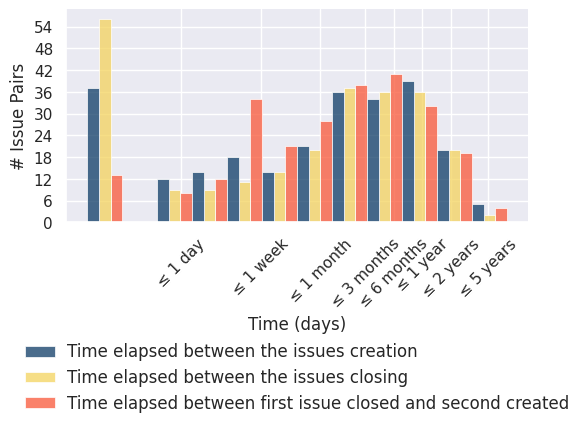

In [15]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd

sns.set_theme(style="darkgrid")
f, ax = plt.subplots(figsize=(6,5.5))
sns.despine(f)

colors = ["#0d3b66", "#f4d35e", "#f95738"]

# Reshape dataframe
df_long = pairs_slim.melt(
    value_vars=["created_diff_days", "closed_diff_days", "closed_to_next_created_days"],
    var_name="event",
    value_name="days"
)

# Optional: nicer legend labels
df_long["event"] = df_long["event"].map({
    "created_diff_days": "Time elapsed between the issues creation",
    "closed_diff_days": "Time elapsed between the issues closing", 
    "closed_to_next_created_days": "Time elapsed between first issue closed and second created"
})

df_long

sns.histplot(
    df_long,
    x="days",
    hue="event",
    multiple="dodge",
    linewidth=.5,
    log_scale=True,
    legend=True,
    palette=colors
)

# Axis formatting
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([1, 7, 30, 90, 180, 365, 730, 1825])
ax.tick_params(axis="x", rotation=45)
ax.set_xticklabels([
    "≤ 1 day",
    "≤ 1 week",
    "≤ 1 month",
    "≤ 3 months",
    "≤ 6 months",
    "≤ 1 year",
    "≤ 2 years", 
    "≤ 5 years"
], fontsize=11)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_xlabel("Time (days)", fontsize=12)
ax.set_ylabel("# Issue Pairs", fontsize=12)

# Legend positioning (same as your original)
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.5, -0.5))
leg.set_loc("upper center")
leg.set_title(None)
leg.set_frame_on(False)

for text in leg.get_texts():
    text.set_fontsize(12)

plt.tight_layout()
plt.savefig("issue_times.pdf", bbox_inches="tight", dpi=300)


In [16]:
prs_pkl = glob.glob(os.path.join('./prs', '*.pkl'))
prs_df = pd.concat([pd.read_pickle(file) for file in prs_pkl], ignore_index=True)
prs_df['repo'] = prs_df['url'].str.extract(r'https?://github\.com/[^/]+/([^/]+)', expand=False)
prs_df

,number,title,url,bodyText,createdAt,mergedAt,repo
0,14541,fix(deps): update dependency mongodb to v6.13.0,https://github.com/nestjs/nest/pull/14541,This PR contains the following updates:\n\n\n\...,2025-01-31T02:02:57Z,2025-01-31T07:19:42Z,nest
1,14538,chore(deps-dev): bump @nestjs/mongoose from 11...,https://github.com/nestjs/nest/pull/14538,Bumps @nestjs/mongoose from 11.0.0 to 11.0.1.\...,2025-01-30T00:03:29Z,2025-01-30T09:31:32Z,nest
2,14536,fix(deps): update dependency @nestjs/mongoose ...,https://github.com/nestjs/nest/pull/14536,This PR contains the following updates:\n\n\n\...,2025-01-29T17:31:23Z,2025-01-30T09:31:49Z,nest
3,14532,fix(deps): update dependency @prisma/client to...,https://github.com/nestjs/nest/pull/14532,This PR contains the following updates:\n\n\n\...,2025-01-28T17:09:19Z,2025-01-29T09:01:53Z,nest
4,14529,chore(deps): update dependency @types/node to ...,https://github.com/nestjs/nest/pull/14529,This PR contains the following updates:\n\n\n\...,2025-01-28T05:39:25Z,2025-01-28T08:41:12Z,nest
...,...,...,...,...,...,...,...
126357,10798,[V3] convert nodes_audio.py to V3 schema,https://github.com/Comfy-Org/ComfyUI/pull/10798,All nodes were tested after conversion:\n\nThi...,2025-11-19T15:22:53Z,2025-12-04T01:35:04Z,ComfyUI
126358,10738,mm: discard async errors from pinning failures,https://github.com/Comfy-Org/ComfyUI/pull/10738,Pretty much every error cudaHostRegister can t...,2025-11-13T16:16:48Z,2025-12-29T23:19:34Z,ComfyUI
126359,10669,[V3] convert nodes_mask.py to V3 schema,https://github.com/Comfy-Org/ComfyUI/pull/10669,Nodes were tested after conversion.\nObjects g...,2025-11-06T15:13:12Z,2025-12-06T04:24:11Z,ComfyUI
126360,10663,[add] tripo3.0,https://github.com/Comfy-Org/ComfyUI/pull/10663,API Node PR Checklist\nScope\n\n Is API Node C...,2025-11-06T06:36:28Z,2025-12-16T01:38:46Z,ComfyUI


In [ ]:
pairs = pd.read_csv('reviewed_fixes.csv')
pairs
# we drop the last 10 rows (they correspond to commits, not PRs, because of spring-boot special case)
pairs = pairs.iloc[:-10].reset_index(drop=True)

,project,source_url,nearest_url,cosine_similarity,issue_source,issue_near,notes,similarity reason,codes,trivial?,developers?,time distance,same issue,Unnamed: 13
0,tabby,https://github.com/Eugeny/tabby/pull/5670,https://github.com/Eugeny/tabby/pull/5743,0.874374,4930,4930,"Both PRs are related to the same issue, and ha...",The pair shares location,"Level class, Faulty fix, Same author of the fix",No,Yes,Same day,Yes,NaN
1,tabby,https://github.com/Eugeny/tabby/pull/8842,https://github.com/Eugeny/tabby/pull/8960,0.844745,8839,8915,Both prs are related to the same UI component ...,The pair shares location,"Level class, Same author of the fix, Similar c...",No,No,24 days,No,NaN
2,tabby,https://github.com/Eugeny/tabby/pull/5907,https://github.com/Eugeny/tabby/pull/6612,0.811244,"3947, 2694, 1492",6355,Both prs are related to the same request for s...,The pair shares intention,"Similar intent, Same author of the fix, Depend...",No,No,3 months,No,NaN
3,tabby,https://github.com/Eugeny/tabby/pull/10043,https://github.com/Eugeny/tabby/pull/10130,0.759524,10012,10129,Both prs are related to hostname issues. The f...,The pair shares location,"Level code line, Faulty fix",No,No,1 month,No,NaN
4,tabby,https://github.com/Eugeny/tabby/pull/10043,https://github.com/Eugeny/tabby/pull/10105,0.750237,10012,10099,Both prs are related to ssh profiles. Is a sim...,The pair shares location,"Level function, Faulty fix",No,No,1 month,No,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,transformers,https://github.com/huggingface/transformers/pu...,https://github.com/huggingface/transformers/pu...,0.950886,11666,11666,11718 reverts the main changes performed by 11...,The pair shares location,Added Removed Code Lines,No,No,2 days,Yes,NaN
236,transformers,https://github.com/huggingface/transformers/pu...,https://github.com/huggingface/transformers/pu...,0.946374,18038,24933,Both PRS are related to the same feature. The ...,The pair shares location,"Similar code actions, Level function, Same aut...",No,No,14 days,No,NaN
237,transformers,https://github.com/huggingface/transformers/pu...,https://github.com/huggingface/transformers/pu...,0.942306,23467,23848,Both PRS are related to the same feature. The ...,The pair shares location,"Similar code actions, Level function, Same aut...",No,In issue,2 days,No,NaN
238,transformers,https://github.com/huggingface/transformers/pu...,https://github.com/huggingface/transformers/pu...,0.941178,11399,11399,"Both PRS share the same files, and can be cons...",The pair shares location,"Evolved fix, Level code line",No,Yes,1 day,Yes,NaN


In [ ]:
# extract last path segment (PR number) and store as nullable integer
pairs['source_pr'] = (
    pairs['source_url']
    .astype(str)
    .str.rstrip('/')               
    .str.split('/')
    .str[-1]
    .replace('', pd.NA)
    .astype('Int64')                
)
pairs['nearest_pr'] = (
    pairs['nearest_url']
    .astype(str)
    .str.rstrip('/')
    .str.split('/')
    .str[-1]
    .replace('', pd.NA)
    .astype('Int64')
)

,project,source_url,nearest_url,cosine_similarity,issue_source,issue_near,notes,similarity reason,codes,trivial?,developers?,time distance,same issue,Unnamed: 13,source_pr,nearest_pr
0,tabby,https://github.com/Eugeny/tabby/pull/5670,https://github.com/Eugeny/tabby/pull/5743,0.874374,4930,4930,"Both PRs are related to the same issue, and ha...",The pair shares location,"Level class, Faulty fix, Same author of the fix",No,Yes,Same day,Yes,NaN,5670,5743
1,tabby,https://github.com/Eugeny/tabby/pull/8842,https://github.com/Eugeny/tabby/pull/8960,0.844745,8839,8915,Both prs are related to the same UI component ...,The pair shares location,"Level class, Same author of the fix, Similar c...",No,No,24 days,No,NaN,8842,8960
2,tabby,https://github.com/Eugeny/tabby/pull/5907,https://github.com/Eugeny/tabby/pull/6612,0.811244,"3947, 2694, 1492",6355,Both prs are related to the same request for s...,The pair shares intention,"Similar intent, Same author of the fix, Depend...",No,No,3 months,No,NaN,5907,6612
3,tabby,https://github.com/Eugeny/tabby/pull/10043,https://github.com/Eugeny/tabby/pull/10130,0.759524,10012,10129,Both prs are related to hostname issues. The f...,The pair shares location,"Level code line, Faulty fix",No,No,1 month,No,NaN,10043,10130
4,tabby,https://github.com/Eugeny/tabby/pull/10043,https://github.com/Eugeny/tabby/pull/10105,0.750237,10012,10099,Both prs are related to ssh profiles. Is a sim...,The pair shares location,"Level function, Faulty fix",No,No,1 month,No,NaN,10043,10105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,transformers,https://github.com/huggingface/transformers/pu...,https://github.com/huggingface/transformers/pu...,0.950886,11666,11666,11718 reverts the main changes performed by 11...,The pair shares location,Added Removed Code Lines,No,No,2 days,Yes,NaN,11682,11718
236,transformers,https://github.com/huggingface/transformers/pu...,https://github.com/huggingface/transformers/pu...,0.946374,18038,24933,Both PRS are related to the same feature. The ...,The pair shares location,"Similar code actions, Level function, Same aut...",No,No,14 days,No,NaN,18046,24993
237,transformers,https://github.com/huggingface/transformers/pu...,https://github.com/huggingface/transformers/pu...,0.942306,23467,23848,Both PRS are related to the same feature. The ...,The pair shares location,"Similar code actions, Level function, Same aut...",No,In issue,2 days,No,NaN,23468,23910
238,transformers,https://github.com/huggingface/transformers/pu...,https://github.com/huggingface/transformers/pu...,0.941178,11399,11399,"Both PRS share the same files, and can be cons...",The pair shares location,"Evolved fix, Level code line",No,Yes,1 day,Yes,NaN,11490,11591


In [ ]:
cols = ['project', 'source_url', 'nearest_url', 'codes', 'trivial?', 'source_pr', 'nearest_pr']
keep = [c for c in cols if c in pairs.columns]
pairs_slim = pairs[keep].copy()

pr_lookup = prs_df.set_index(['repo', 'url'])
created_map = pr_lookup['createdAt'].to_dict()
merged_map = pr_lookup['mergedAt'].to_dict()

pairs_slim['pr_1_key'] = list(zip(pairs_slim['project'], pairs_slim['source_url']))
pairs_slim['pr_2_key'] = list(zip(pairs_slim['project'], pairs_slim['nearest_url']))

pairs_slim['pr_1_createdAt'] = pairs_slim['pr_1_key'].map(created_map)
pairs_slim['pr_1_mergedAt']  = pairs_slim['pr_1_key'].map(merged_map)
pairs_slim['pr_2_createdAt'] = pairs_slim['pr_2_key'].map(created_map)
pairs_slim['pr_2_mergedAt']  = pairs_slim['pr_2_key'].map(merged_map)

pairs_slim.drop(columns=['pr_1_key', 'pr_2_key'], inplace=True)

pairs_slim

pairs_slim['pr_1_createdAt_dt'] = pd.to_datetime(pairs_slim['pr_1_createdAt'])
pairs_slim['pr_2_createdAt_dt'] = pd.to_datetime(pairs_slim['pr_2_createdAt'])
pairs_slim['pr_1_mergedAt_dt']  = pd.to_datetime(pairs_slim['pr_1_mergedAt'])
pairs_slim['pr_2_mergedAt_dt']  = pd.to_datetime(pairs_slim['pr_2_mergedAt'])

pairs_slim['created_diff'] = pairs_slim['pr_2_createdAt_dt'] - pairs_slim['pr_1_createdAt_dt']
pairs_slim['merged_diff']  = pairs_slim['pr_2_mergedAt_dt']  - pairs_slim['pr_1_mergedAt_dt']

def _merged_to_next_created(row):
    if row['source_pr'] < row['nearest_pr']:
        diff = row['pr_1_mergedAt_dt'] - row['pr_2_createdAt_dt']
    else:
        diff = row['pr_2_mergedAt_dt'] - row['pr_1_createdAt_dt']
    return diff

pairs_slim['merged_to_next_created_diff'] = pairs_slim.apply(_merged_to_next_created, axis=1)
pairs_slim['merged_to_next_created_days'] = pairs_slim['merged_to_next_created_diff'].abs().dt.total_seconds() / 86400


pairs_slim['created_diff_days'] = pairs_slim['created_diff'].abs().dt.total_seconds() / 86400
pairs_slim['merged_diff_days']  = pairs_slim['merged_diff'].abs().dt.total_seconds()  / 86400

,project,source_url,nearest_url,codes,trivial?,source_pr,nearest_pr,pr_1_createdAt,pr_1_mergedAt,pr_2_createdAt,...,pr_1_createdAt_dt,pr_2_createdAt_dt,pr_1_mergedAt_dt,pr_2_mergedAt_dt,created_diff,merged_diff,merged_to_next_created_diff,merged_to_next_created_days,created_diff_days,merged_diff_days
0,tabby,https://github.com/Eugeny/tabby/pull/5670,https://github.com/Eugeny/tabby/pull/5743,"Level class, Faulty fix, Same author of the fix",No,5670,5743,2022-02-05T23:11:38Z,2022-02-07T15:31:36Z,2022-02-13T16:44:32Z,...,2022-02-05 23:11:38+00:00,2022-02-13 16:44:32+00:00,2022-02-07 15:31:36+00:00,2022-02-13 18:51:33+00:00,7 days 17:32:54,6 days 03:19:57,-7 days +22:47:04,6.050648,7.731181,6.138854
1,tabby,https://github.com/Eugeny/tabby/pull/8842,https://github.com/Eugeny/tabby/pull/8960,"Level class, Same author of the fix, Similar c...",No,8842,8960,2023-08-17T17:35:40Z,2023-08-17T18:53:12Z,2023-09-10T16:00:18Z,...,2023-08-17 17:35:40+00:00,2023-09-10 16:00:18+00:00,2023-08-17 18:53:12+00:00,2023-09-20 19:53:55+00:00,23 days 22:24:38,34 days 01:00:43,-24 days +02:52:54,23.879931,23.933773,34.042164
2,tabby,https://github.com/Eugeny/tabby/pull/5907,https://github.com/Eugeny/tabby/pull/6612,"Similar intent, Same author of the fix, Depend...",No,5907,6612,2022-03-08T17:40:02Z,2022-03-26T10:47:31Z,2022-06-15T10:23:45Z,...,2022-03-08 17:40:02+00:00,2022-06-15 10:23:45+00:00,2022-03-26 10:47:31+00:00,2022-09-04 16:00:05+00:00,98 days 16:43:43,162 days 05:12:34,-81 days +00:23:46,80.983495,98.697025,162.217060
3,tabby,https://github.com/Eugeny/tabby/pull/10043,https://github.com/Eugeny/tabby/pull/10130,"Level code line, Faulty fix",No,10043,10130,2024-11-05T16:22:11Z,2024-11-06T11:41:04Z,2024-12-29T11:31:10Z,...,2024-11-05 16:22:11+00:00,2024-12-29 11:31:10+00:00,2024-11-06 11:41:04+00:00,2025-01-01 00:08:21+00:00,53 days 19:08:59,55 days 12:27:17,-53 days +00:09:54,52.993125,53.797905,55.518947
4,tabby,https://github.com/Eugeny/tabby/pull/10043,https://github.com/Eugeny/tabby/pull/10105,"Level function, Faulty fix",No,10043,10105,2024-11-05T16:22:11Z,2024-11-06T11:41:04Z,2024-12-23T00:26:48Z,...,2024-11-05 16:22:11+00:00,2024-12-23 00:26:48+00:00,2024-11-06 11:41:04+00:00,2025-01-01 00:13:02+00:00,47 days 08:04:37,55 days 12:31:58,-47 days +11:14:16,46.531759,47.336539,55.522199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,transformers,https://github.com/huggingface/transformers/pu...,https://github.com/huggingface/transformers/pu...,Added Removed Code Lines,No,11682,11718,2021-05-11T15:48:05Z,2021-05-11T16:02:48Z,2021-05-13T18:49:13Z,...,2021-05-11 15:48:05+00:00,2021-05-13 18:49:13+00:00,2021-05-11 16:02:48+00:00,2021-05-13 20:11:12+00:00,2 days 03:01:08,2 days 04:08:24,-3 days +21:13:35,2.115567,2.125787,2.172500
236,transformers,https://github.com/huggingface/transformers/pu...,https://github.com/huggingface/transformers/pu...,"Similar code actions, Level function, Same aut...",No,18046,24993,2022-07-06T17:36:09Z,2022-07-07T12:17:49Z,2023-07-21T14:06:43Z,...,2022-07-06 17:36:09+00:00,2023-07-21 14:06:43+00:00,2022-07-07 12:17:49+00:00,2023-07-21 14:30:17+00:00,379 days 20:30:34,379 days 02:12:28,-380 days +22:11:06,379.075625,379.854560,379.091991
237,transformers,https://github.com/huggingface/transformers/pu...,https://github.com/huggingface/transformers/pu...,"Similar code actions, Level function, Same aut...",No,23468,23910,2023-05-19T11:03:17Z,2023-05-19T14:12:25Z,2023-05-31T15:05:31Z,...,2023-05-19 11:03:17+00:00,2023-05-31 15:05:31+00:00,2023-05-19 14:12:25+00:00,2023-05-31 15:36:56+00:00,12 days 04:02:14,12 days 01:24:31,-13 days +23:06:54,12.036875,12.168218,12.058692
238,transformers,https://github.com/huggingface/transformers/pu...,https://github.com/huggingface/transformers/pu...,"Evolved fix, Level code line",No,11490,11591,2021-04-28T12:38:08Z,2021-05-04T07:45:13Z,2021-05-05T06:45:56Z,...,2021-04-28 12:38:08+00:00,2021-05-05 06:45:56+00:00,2021-05-04 07:45:13+00:00,202

In [22]:
pairs_slim.describe()

,source_pr,nearest_pr,created_diff,merged_diff,merged_to_next_created_diff,merged_to_next_created_days,created_diff_days,merged_diff_days
count,240.0,240.0,240,240,240,240.000000,240.000000,240.000000
mean,20415.7,21452.4875,85 days 12:54:22.262500,82 days 00:05:16.433333333,-163 days +18:43:13.050000,164.962173,171.764879,167.809546
std,16579.059277,17322.986167,305 days 19:37:29.906524224,304 days 08:17:35.406742892,266 days 09:29:44.716309652,264.699259,266.917916,266.647861
min,182.0,207.0,-1287 days +06:40:21,-1286 days +01:29:42,-1397 days +17:48:31,0.000394,0.000162,0.000035
25%,10423.25,9539.0,1 days 06:24:48,0 days 13:58:42,-201 days +09:07:00.250000,3.866441,4.769876,4.580362
50%,14500.5,15394.5,27 days 09:56:02,28 days 07:06:15.500000,-46 days +10:23:55.500000,46.878999,54.903970,52.245619
75%,26797.0,27873.0,136 days 03:38:57.250000,127 days 14:01:02.500000,-2 days +19:26:04,202.638388,214.943212,202.786916
max,114851.0,116666.0,1397 days 04:02:57,1416 days 23:35:42,229 days 21:40:14,1396.257975,1397.168715,1416.983125


In [25]:
# round to nearest integer and preserve NA using pandas nullable integer dtype
pairs_slim['created_diff_days'] = pairs_slim['created_diff_days'].round().astype('Int64')
pairs_slim['merged_diff_days']  = pairs_slim['merged_diff_days'].round().astype('Int64')
pairs_slim['merged_to_next_created_days']  = pairs_slim['merged_to_next_created_days'].round().astype('Int64')

# convert nullable integers to float (NaN preserved) and replace exact 0 with 0.1 for log-scale plotting
for col in ['created_diff_days', 'merged_diff_days', 'merged_to_next_created_days']:
    pairs_slim[col] = pairs_slim[col].astype(float)
    pairs_slim.loc[pairs_slim[col] == 0, col] = 0.1

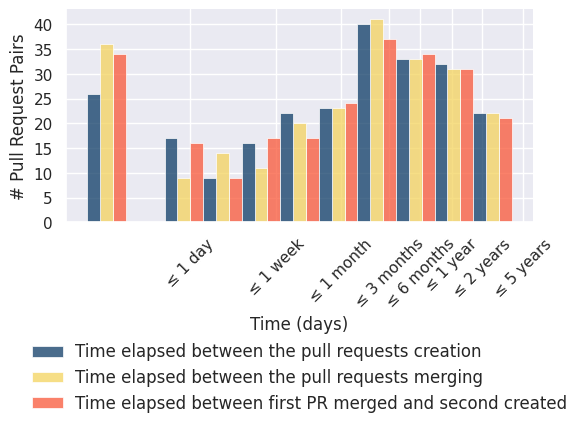

In [29]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd

sns.set_theme(style="darkgrid")
f, ax = plt.subplots(figsize=(6,5.5))
sns.despine(f)

colors = ["#0d3b66", "#f4d35e", "#f95738"]

# Reshape dataframe
df_long = pairs_slim.melt(
    value_vars=["created_diff_days", "merged_diff_days", "merged_to_next_created_days"],
    var_name="event",
    value_name="days"
)

# Optional: nicer legend labels
df_long["event"] = df_long["event"].map({
    "created_diff_days": "Time elapsed between the pull requests creation",
    "merged_diff_days": "Time elapsed between the pull requests merging", 
    "merged_to_next_created_days": "Time elapsed between first PR merged and second created"
})

df_long

sns.histplot(
    df_long,
    x="days",
    hue="event",
    multiple="dodge",
    linewidth=.5,
    log_scale=True,
    legend=True,
    palette=colors
)

# Axis formatting
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([1, 7, 30, 90, 180, 365, 730, 1825])
ax.tick_params(axis="x", rotation=45)
ax.set_xticklabels([
    "≤ 1 day",
    "≤ 1 week",
    "≤ 1 month",
    "≤ 3 months",
    "≤ 6 months",
    "≤ 1 year",
    "≤ 2 years", 
    "≤ 5 years"
], fontsize=11)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_xlabel("Time (days)", fontsize=12)
ax.set_ylabel("# Pull Request Pairs", fontsize=12)

leg = ax.get_legend()
leg.set_bbox_to_anchor((0.5, -0.5))
leg.set_loc("upper center")
leg.set_title(None)
leg.set_frame_on(False)

for text in leg.get_texts():
    text.set_fontsize(12)

plt.tight_layout()
plt.savefig("pr_times.pdf", bbox_inches="tight", dpi=300)
